### Sentiment Analysis Using Logistic Regression

In [35]:
# load in the clean data
import pandas as pd
import numpy as np  

df = pd.read_parquet('../data/clean/reviews_clean.parquet')
df.head()

,verification_status,review_body,published_date,rating,aircraft,type_of_traveler,seat_type,recommended,year,month,day,cumulative_avg_rating
0,Not Verified,Very good flight following an equally good fli...,2025-01-20,9.0,A320,Solo Leisure,Business Class,yes,2025,1,20,4.664271
1,Not Verified,An hour's delay due to late arrival of the inc...,2025-01-19,7.0,A319,Family Leisure,Economy Class,yes,2025,1,19,4.663158
2,Trip Verified,I booked through BA because Loganair don’t hav...,2025-01-15,1.0,None,Solo Leisure,Economy Class,no,2025,1,15,4.662558
3,Trip Verified,British airways lost bags in LHR then found th...,2025-01-09,1.0,None,Family Leisure,Premium Economy,no,2025,1,9,4.663499
4,Trip Verified,The check in process and reward/loyalty progra...,2025-01-05,1.0,A320,Business,Economy Class,no,2025,1,5,4.664440


In [36]:
# columns we need
df = df[['review_body', 'recommended']]
df.head()

,review_body,recommended
0,Very good flight following an equally good fli...,yes
1,An hour's delay due to late arrival of the inc...,yes
2,I booked through BA because Loganair don’t hav...,no
3,British airways lost bags in LHR then found th...,no
4,The check in process and reward/loyalty progra...,no


In [37]:
# change recommended to 0 and 1
df.replace({'recommended': {'yes': 1, 'no': 0}}, inplace=True)


C:\Users\ryans\AppData\Local\Temp\ipykernel_53740\223845183.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'recommended': {'yes': 1, 'no': 0}}, inplace=True)


In [38]:
df.head()

,review_body,recommended
0,Very good flight following an equally good fli...,1
1,An hour's delay due to late arrival of the inc...,1
2,I booked through BA because Loganair don’t hav...,0
3,British airways lost bags in LHR then found th...,0
4,The check in process and reward/loyalty progra...,0


In [39]:
# distribution of recommended
df['recommended'].value_counts(normalize=True)

recommended
0    0.627053
1    0.372947
Name: proportion, dtype: float64

In [40]:
# libraries needed for our sentiment analysis
import nltk
from nltk import word_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#### Use CountVectorizer

We will be using **CountVectorizer** with the default parameters since the reviews we looked at were not very messy. The default pattern for the CountVectorizer is r'(?u)\b\w\w+\b' which matches any alphabetical/numerical characters more than length=1 and underscores. This also ignores punctuation and symbols so it would work fine in our code. 

In [41]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# split the data
X = df['review_body']
y = df['recommended']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# fit transform the training data
X_train_vec = count_vectorizer.fit_transform(X_train)

# transform the test data
X_test_vec = count_vectorizer.transform(X_test)

#### Logistic Regression Model

In [42]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# initialize the model
log_reg = LogisticRegression(max_iter=1000)

# fit the model
log_reg.fit(X_train_vec, y_train)

# predict
y_pred = log_reg.predict(X_test_vec)



In [43]:
# metrics
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.93      0.91       496
           1       0.87      0.80      0.83       284

    accuracy                           0.88       780
   macro avg       0.88      0.87      0.87       780
weighted avg       0.88      0.88      0.88       780



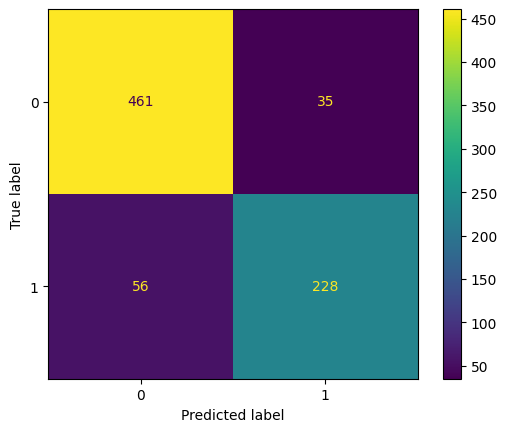

In [44]:
# confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay

# display
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_vec, y_test)


In [57]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       496
           1       0.87      0.80      0.83       284

    accuracy                           0.88       780
   macro avg       0.88      0.87      0.87       780
weighted avg       0.88      0.88      0.88       780



#### TF-IDF

Let's use a TF-IDF approach to put weights on our terms.

In [45]:
# import the TfidfTransformer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer

# initialize the TfidfTransformer
tfidf = TfidfTransformer()

# fit transform the training data
X_train_tfidf = tfidf.fit_transform(X_train_vec)

# transform the test data
X_test_tfidf = tfidf.transform(X_test_vec)

# initialize the model
log_reg_tfidf = LogisticRegression(max_iter=1000)

# fit the model
log_reg_tfidf.fit(X_train_tfidf, y_train)

# predict
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

This model does a better job than the first model at predicting negative sentiments but does a worse job at predicting positive sentiments. 

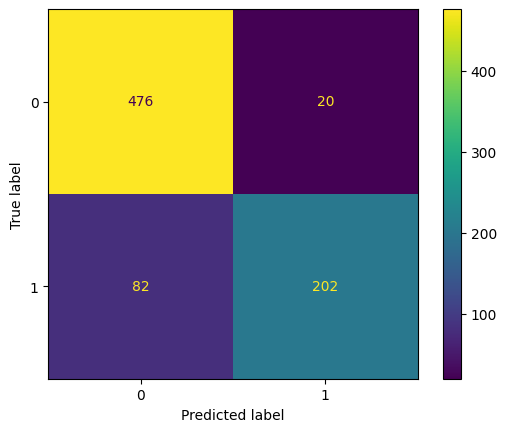

In [46]:
# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(log_reg_tfidf, X_test_tfidf, y_test)

In [47]:
# classification report
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       496
           1       0.91      0.71      0.80       284

    accuracy                           0.87       780
   macro avg       0.88      0.84      0.85       780
weighted avg       0.87      0.87      0.87       780



#### Naive Bayes Classifier

This model is far too harsh on the predictions. Resampling or callibrating the model can show better results.

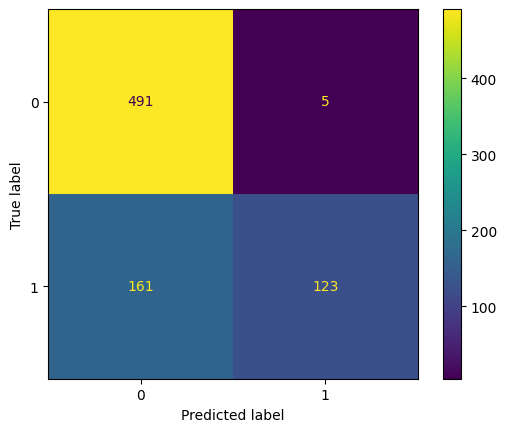

In [48]:
# make naive bayes classifier
from sklearn.naive_bayes import MultinomialNB

# initialize the model
nb = MultinomialNB()

# fit the model
nb.fit(X_train_tfidf, y_train)

# predict
y_pred_nb = nb.predict(X_test_tfidf)

# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(nb, X_test_tfidf, y_test)

In [49]:
# classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86       496
           1       0.96      0.43      0.60       284

    accuracy                           0.79       780
   macro avg       0.86      0.71      0.73       780
weighted avg       0.83      0.79      0.76       780



#### Random Forest Model

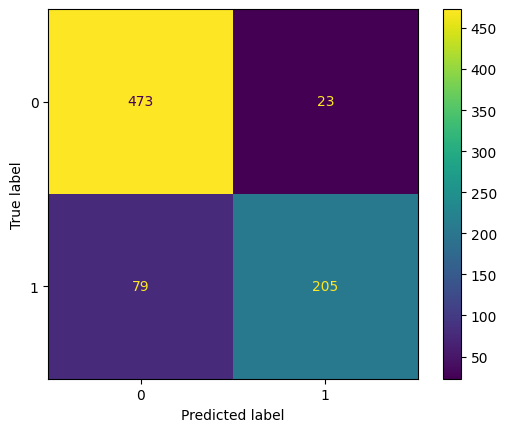

In [50]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# initialize the model
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train_tfidf, y_train)

# predict
y_pred_rf = rf.predict(X_test_tfidf)

# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(rf, X_test_tfidf, y_test)

In [51]:
# classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       496
           1       0.90      0.72      0.80       284

    accuracy                           0.87       780
   macro avg       0.88      0.84      0.85       780
weighted avg       0.87      0.87      0.87       780



#### XGBOOST Classifier

c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1169, number of negative: 1947
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52328
[LightGBM] [Info] Number of data points in the train set: 3116, number of used features: 1630
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375160 -> initscore=-0.510141
[LightGBM] [Info] Start training from score -0.510141


c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ryans\Desktop\british_airways\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


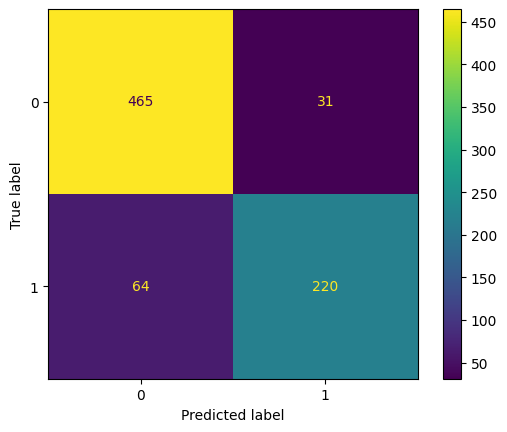

In [55]:
# LightBGM classifier
from lightgbm import LGBMClassifier

# initialize the model
lgbm = LGBMClassifier()

# fit the model
lgbm.fit(X_train_tfidf, y_train)

# predict
y_pred_lgbm = lgbm.predict(X_test_tfidf)

# new confusion matrix display
ConfusionMatrixDisplay.from_estimator(lgbm, X_test_tfidf, y_test)

In [56]:
# classification report
print(classification_report(y_test, y_pred_lgbm))


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       496
           1       0.88      0.77      0.82       284

    accuracy                           0.88       780
   macro avg       0.88      0.86      0.86       780
weighted avg       0.88      0.88      0.88       780



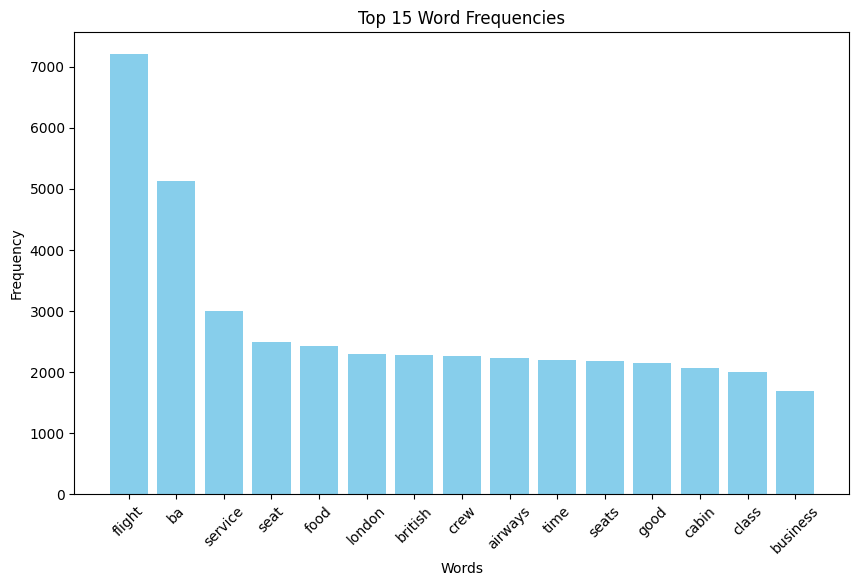

In [34]:
import matplotlib.pyplot as plt
# make a copy of our data
df_copy = df.copy()

# Initialize CountVectorizer for all sentiments
vectorizer_total = CountVectorizer(stop_words='english')

# Fit and transform the text data
X = vectorizer_total.fit_transform(df_copy['review_body'])

# Sum the counts of each word
word_counts = X.toarray().sum(axis=0)

# Create a DataFrame with words and their frequencies
words_df = pd.DataFrame({'word': vectorizer_total.get_feature_names_out(), 'count': word_counts})

# Sort the DataFrame by count in descending order
words_df = words_df.sort_values(by='count', ascending=False)

# Plot the top 10 words
plt.figure(figsize=(10, 6))
plt.bar(words_df['word'][:15], words_df['count'][:15], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Word Frequencies')
plt.xticks(rotation=45)
plt.show()
